In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# Full treatment names
treatment_names = {'sal': 'Vehicle', 'fen': 'Fentanyl'}

# Color mapping
treatment_cmaps = {
    'Fentanyl': plt.cm.Blues,
    'Vehicle': plt.cm.Reds
}

# lighter color for shaded region
def get_group_color(treatment_code, cohort):
    full_treatment = treatment_names[treatment_code]
    cmap = treatment_cmaps[full_treatment]
    shade = 0.7 if cohort == 1 else 0.4
    return cmap(shade)

#### Preprocess
Convert Day from text to numerical format

In [15]:
df = pd.read_csv('Fen_Veh_weights.csv')
df["Day"] = df["Day"].str.split().str[-1].astype(int)
df

,Cohort,Mouse ID,Treatment,Day,Weight
0,1,M1,fen,1,24.5
1,1,M2,sal,1,27.0
2,1,M3,fen,1,27.2
3,1,M4,sal,1,27.0
4,1,M5,fen,1,25.3
...,...,...,...,...,...
215,2,M16,sal,11,28.4
216,2,M17,fen,11,26.1
217,2,M18,sal,11,26.6
218,2,M19,fen,11,28.6


#### Each Invididual Mouse by Day

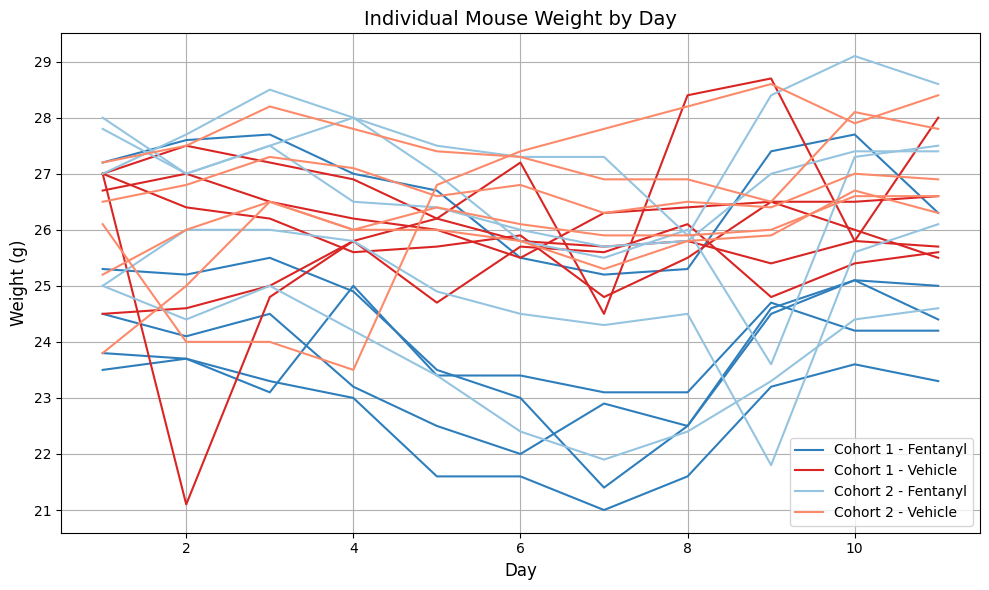

In [18]:
plt.figure(figsize=(10, 6))

# Cohort and treatment forms 4 groups in total
for (cohort, treatment), grp in df.groupby(['Cohort', 'Treatment']):
    color = get_group_color(treatment, cohort)
    
    # label group once for legend
    label = f'Cohort {cohort} - {treatment_names[treatment]}'
    # plot for individual mouse by ID
    for i, (mid, mdata) in enumerate(grp.groupby('Mouse ID')):
        plt.plot(mdata['Day'], mdata['Weight'], color=color,
                 label=label if i == 0 else "")

# 4 legends
plt.legend(handles=[
    plt.Line2D([], [], color=get_group_color(t, c),
               label=f'Cohort {c} - {treatment_names[t]}')
    for c in sorted(df['Cohort'].unique())
    for t in df['Treatment'].unique()
], fontsize=10)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Weight (g)', fontsize=12)
plt.title('Individual Mouse Weight by Day', fontsize=14)
plt.tight_layout()
plt.grid()
plt.show()

#### Weight Changes of Individual Mouse

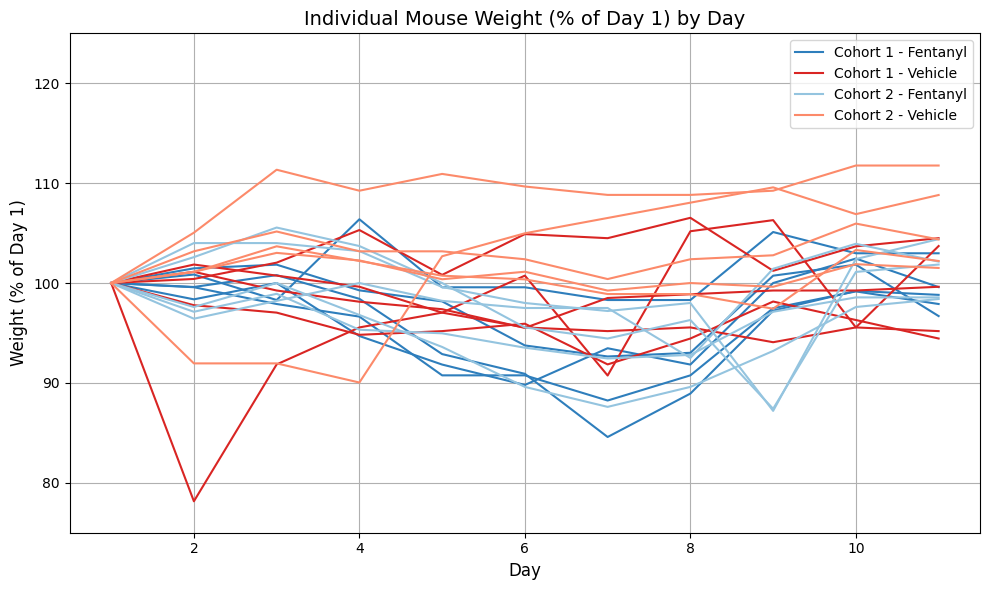

In [23]:
# for quick reference to Day 1 baseline weight
baseline = df[df['Day'] == 1].set_index('Mouse ID')['Weight']
df_pct = df.copy()

# divide each weight by baseline weight
df_pct['Weight_pct'] = df_pct.apply(
    lambda r: r['Weight'] / baseline[r['Mouse ID']] * 100, axis=1)

# Similar plotting logic
plt.figure(figsize=(10, 6))
for (cohort, treatment), grp in df_pct.groupby(['Cohort', 'Treatment']):
    color = get_group_color(treatment, cohort)
    for mdata in grp.groupby('Mouse ID'):
        plt.plot(mdata[1]['Day'], mdata[1]['Weight_pct'], color=color)
        
plt.legend(handles=[
    plt.Line2D([], [], color=get_group_color(t, c),
               label=f'Cohort {c} - {treatment_names[t]}')
    for c in sorted(df_pct['Cohort'].unique())
    for t in df_pct['Treatment'].unique()
], fontsize=10)
plt.ylim(75, 125)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Weight (% of Day 1)', fontsize=12)
plt.title('Individual Mouse Weight (% of Day 1) by Day', fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()


# Group Level Mean and Standard Error

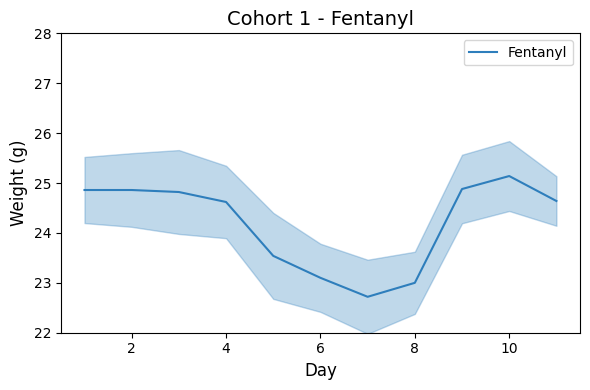

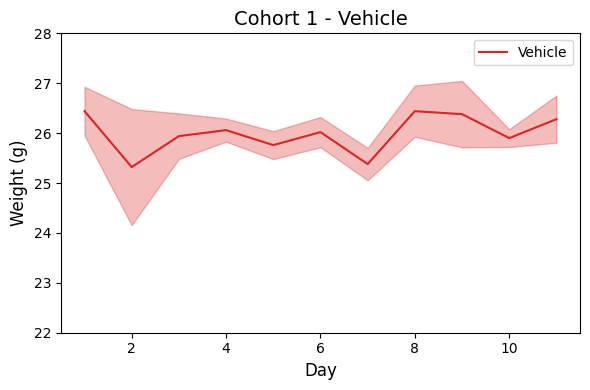

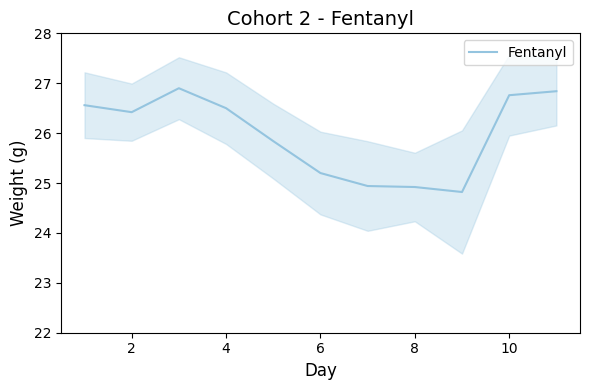

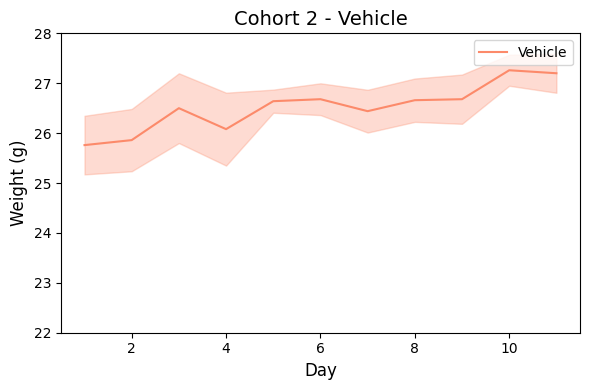

In [25]:
for (cohort, treatment), grp in df.groupby(['Cohort', 'Treatment']):
    full_treat = treatment_names[treatment]
    stats = grp.groupby('Day')['Weight'].agg(['mean', lambda x: sem(x, nan_policy='omit')])
    stats.columns = ['mean', 'sem']
    plt.figure(figsize=(6, 4))
    plt.plot(stats.index, stats['mean'], label=full_treat,
             color=get_group_color(treatment, cohort))
    plt.fill_between(stats.index,
                     stats['mean'] - stats['sem'],
                     stats['mean'] + stats['sem'],
                     alpha=0.3,
                     color=get_group_color(treatment, cohort))
    plt.ylim(22, 28)
    plt.xlabel('Day', fontsize=12)
    plt.ylabel('Weight (g)', fontsize=12)
    plt.title(f'Cohort {cohort} - {full_treat}', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

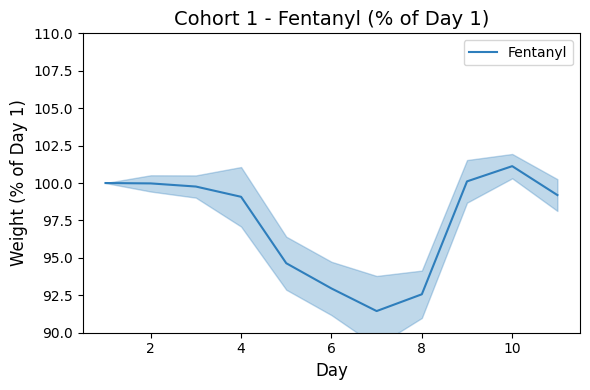

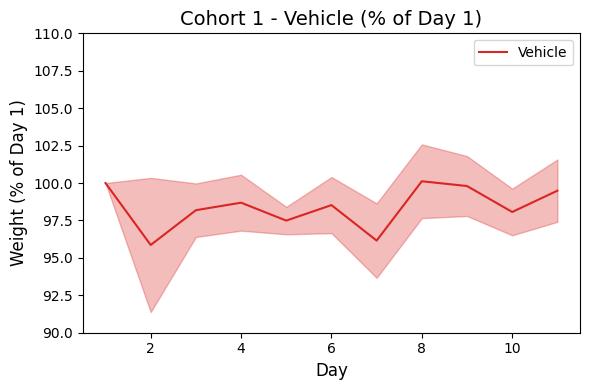

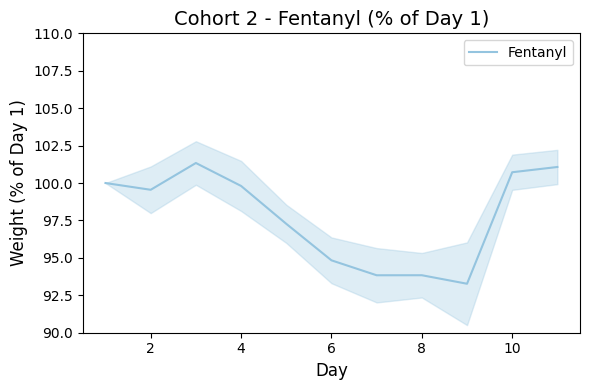

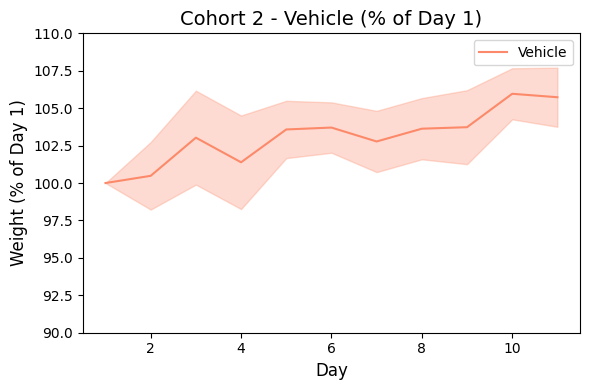

In [27]:
for (cohort, treatment), grp in df_pct.groupby(['Cohort', 'Treatment']):
    full_treat = treatment_names[treatment]
    stats = grp.groupby('Day')['Weight_pct'].agg(['mean', lambda x: sem(x, nan_policy='omit')])
    stats.columns = ['mean', 'sem']
    plt.figure(figsize=(6, 4))
    plt.plot(stats.index, stats['mean'], label=full_treat,
             color=get_group_color(treatment, cohort))
    plt.fill_between(stats.index,
                     stats['mean'] - stats['sem'],
                     stats['mean'] + stats['sem'],
                     alpha=0.3,
                     color=get_group_color(treatment, cohort))
    
    plt.ylim(90, 110)
    plt.xlabel('Day', fontsize=12)
    plt.ylabel('Weight (% of Day 1)', fontsize=12)
    plt.title(f'Cohort {cohort} - {full_treat} (% of Day 1)', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

#### Check Batch effect

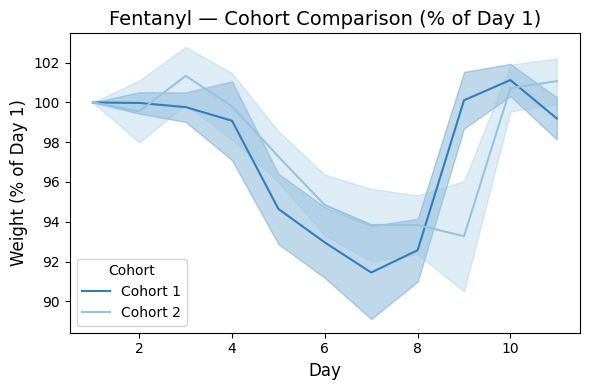

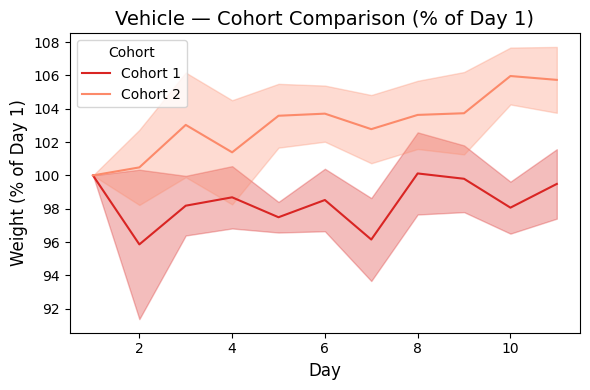

In [28]:
for treatment in df_pct['Treatment'].unique():
    full_treat = treatment_names[treatment]
    plt.figure(figsize=(6, 4))
    for cohort in sorted(df_pct['Cohort'].unique()):
        grp = df_pct[(df_pct['Treatment'] == treatment) & (df_pct['Cohort'] == cohort)]
        stats = grp.groupby('Day')['Weight_pct'].agg(['mean', lambda x: sem(x, nan_policy='omit')])
        stats.columns = ['mean', 'sem']
        color = get_group_color(treatment, cohort)
        plt.plot(stats.index, stats['mean'], label=f'Cohort {cohort}', color=color)
        plt.fill_between(
            stats.index,
            stats['mean'] - stats['sem'],
            stats['mean'] + stats['sem'],
            alpha=0.3,
            color=color
        )
    plt.xlabel('Day', fontsize=12)
    plt.ylabel('Weight (% of Day 1)', fontsize=12)
    plt.title(f'{full_treat} — Cohort Comparison (% of Day 1)', fontsize=14)
    plt.legend(title='Cohort', fontsize=10)
    plt.tight_layout()
    plt.show()

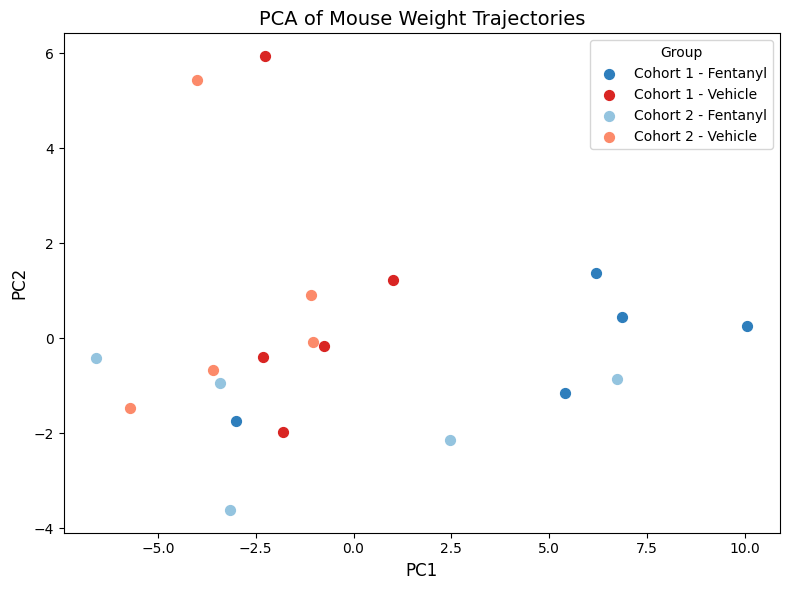

In [29]:
# Cell 6: PCA of Mouse Weight Trajectories

from sklearn.decomposition import PCA

# 1. Pivot to wide format: rows = Mouse ID, columns = Day
data_matrix = df.pivot(index='Mouse ID', columns='Day', values='Weight')

# 2. Capture metadata
meta = df[['Mouse ID', 'Treatment', 'Cohort']].drop_duplicates().set_index('Mouse ID')

# 3. Handle any missing days by filling with each mouse’s mean
data_filled = data_matrix.fillna(data_matrix.mean(axis=1), axis=0)

# 4. Run PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(data_filled.values)

# 5. Build DataFrame of PCs + metadata
pca_df = pd.DataFrame(pcs, index=data_filled.index, columns=['PC1', 'PC2'])
pca_df = pca_df.join(meta)

# 6. Plot
plt.figure(figsize=(8, 6))
for (cohort, treatment), grp in pca_df.groupby(['Cohort', 'Treatment']):
    color = get_group_color(treatment, cohort)
    label = f'Cohort {cohort} - {treatment_names[treatment]}'
    plt.scatter(grp['PC1'], grp['PC2'], color=color, s=50, label=label)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.title('PCA of Mouse Weight Trajectories', fontsize=14)
plt.legend(fontsize=10, title='Group')
plt.tight_layout()
plt.show()


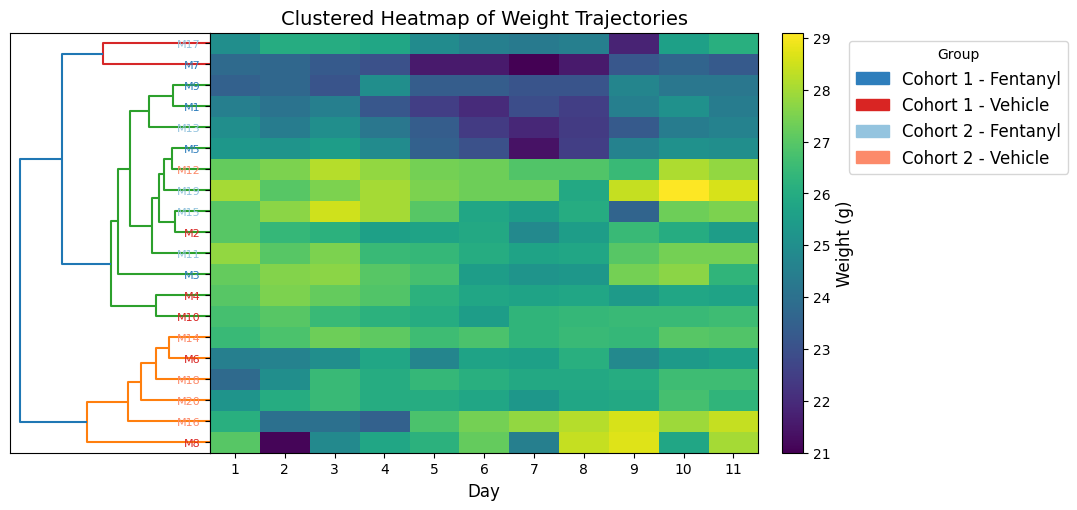

In [35]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.patches as mpatches

# 1. Pivot to wide format and fill missing
data_matrix = df.pivot(index='Mouse ID', columns='Day', values='Weight')
data_filled = data_matrix.fillna(data_matrix.mean(axis=1), axis=0)

# 2. Compute linkage for rows (mice)
row_link = linkage(data_filled.values, method='average', metric='euclidean')
dendro = dendrogram(row_link, no_plot=True)
row_order = dendro['leaves']

# 3. Order data
ordered_data = data_filled.values[row_order, :]
ordered_ids = data_filled.index[row_order]
ordered_meta = meta.loc[ordered_ids]

# 4. Set up figure with dendrogram + heatmap
fig = plt.figure(figsize=(10, 6))

# Dendrogram axis (left)
ax1 = fig.add_axes([0.1, 0.1, 0.2, 0.7])
dendrogram(row_link, orientation='left', ax=ax1, no_labels=True, color_threshold=None)
ax1.set_xticks([])
ax1.set_yticks([])

# Heatmap axis (right)
ax2 = fig.add_axes([0.3, 0.1, 0.6, 0.7])
im = ax2.imshow(ordered_data, aspect='auto', interpolation='nearest')
ax2.set_xticks(np.arange(data_filled.shape[1]))
ax2.set_xticklabels(data_filled.columns, fontsize=10)
ax2.set_yticks(np.arange(len(ordered_ids)))
ax2.set_yticklabels(ordered_ids, fontsize=8)

# Color y-axis labels by cohort & treatment
for idx, mouse_id in enumerate(ordered_ids):
    coh = ordered_meta.loc[mouse_id, 'Cohort']
    trt = ordered_meta.loc[mouse_id, 'Treatment']
    col = get_group_color(trt, coh)
    ax2.get_yticklabels()[idx].set_color(col)

ax2.set_xlabel('Day', fontsize=12)
ax2.set_title('Clustered Heatmap of Weight Trajectories', fontsize=14)

# Colorbar
cbar = fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('Weight (g)', fontsize=12)

# Legend for cohort-treatment groups
handles = []
labels = []
for coh in sorted(df['Cohort'].unique()):
    for trt in df['Treatment'].unique():
        full_trt = treatment_names[trt]
        color = get_group_color(trt, coh)
        handles.append(mpatches.Patch(color=color))
        labels.append(f'Cohort {coh} - {full_trt}')
ax2.legend(handles, labels, title='Group', bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=12)

plt.show()
